# Sistema de detección de enlaces spam
Queremos implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

In [5]:
import pandas as pd
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import randint
# To save models
import json
import pickle
from pickle import dump

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('/workspaces/ML-web-app-using-Streamlit/data/raw/12 url_spam.csv', sep=',')

df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [7]:
df.dtypes

url        object
is_spam      bool
dtype: object

In [8]:
df.shape

(2999, 2)

In [9]:
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2369, 2)

## Paso 2: Preprocesa los enlaces
Utiliza lo visto en este módulo para transformar los datos para compatibilizarlos con el modelo que queremos entrenar. Segmenta las URLs en partes según sus signos de puntuación, elimina las stopwords, lematiza, etcétera.

Asegúrate de dividir convenientemente el conjunto de datos en train y test como hemos visto en lecciones anteriores.


### Cleaning
Para poder entrenar el modelo es necesario aplicar antes un proceso de transformación al texto. Comenzamos transformando el texto a minúsculas y eliminando signos de puntuación y caracteres especiales:

In [10]:
# Pongo con 0 y 1 el boleano de True y False.

df["is_spam"] = df["is_spam"].astype(int)
df.head

<bound method NDFrame.head of                                                     url  is_spam
0     https://briefingday.us8.list-manage.com/unsubs...        1
1                                https://www.hvper.com/        1
2                    https://briefingday.com/m/v4n3i4f3        1
3      https://briefingday.com/n/20200618/m#commentform        0
4                           https://briefingday.com/fan        1
...                                                 ...      ...
2364  https://www.theverge.com/2020/6/29/21306889/di...        0
2365  https://www.smartcitiesworld.net/news/news/dee...        0
2366  https://techcrunch.com/2019/07/04/an-optimisti...        0
2367  https://www.technologyreview.com/2019/12/20/13...        0
2368       https://www.bbc.com/news/technology-51018758        0

[2369 rows x 2 columns]>

In [11]:
# Limpiar URL.

def preprocess_text(text):
    text = text.lower()
    # Reemplaza el contenido de las etiquetas (tags) html por <>
    text = re.sub("</?.*?>", " <> ", text)
    # Reemplaza aquello que no es una letra (a-z) o un espacio en blanco por un espacio en blanco
    text = re.sub(r'[^a-z ]', " ", text)
    # Reemplaza múltiples espacios en blanco en uno solo
    text = re.sub(r'\s+', " ", text)
        # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)
         # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
        # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())
    return text.split()

In [12]:
df["url"] = df["url"].apply(preprocess_text)
df

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2364,"[https, www, theverge, com, disney, deepfake, ...",0
2365,"[https, www, smartcitiesworld, net, news, news...",0
2366,"[https, techcrunch, com, an, optimistic, view,...",0
2367,"[https, www, technologyreview, com, this, star...",0


### Lematización y Stopwords.

In [13]:
# Instancia lematizador
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer=lemmatizer):
    # lematiza
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # saca stop words
    tokens = [word for word in tokens if word not in stop_words]
    # se queda con las de largo mayor a
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
df["url"] = df["url"].apply(lemmatize_text)
df.head

<bound method NDFrame.head of                                                     url  is_spam
0        [http, briefingday, list, manage, unsubscribe]        1
1                                         [http, hvper]        1
2                                   [http, briefingday]        1
3                      [http, briefingday, commentform]        0
4                                   [http, briefingday]        1
...                                                 ...      ...
2364  [http, theverge, disney, deepfake, face, swapp...        0
2365  [http, smartcitiesworld, news, news, deepfake,...        0
2366    [http, techcrunch, optimistic, view, deepfakes]        0
2367  [http, technologyreview, startup, claim, deepf...        0
2368                           [http, news, technology]        0

[2369 rows x 2 columns]>

### Nube de palabras.

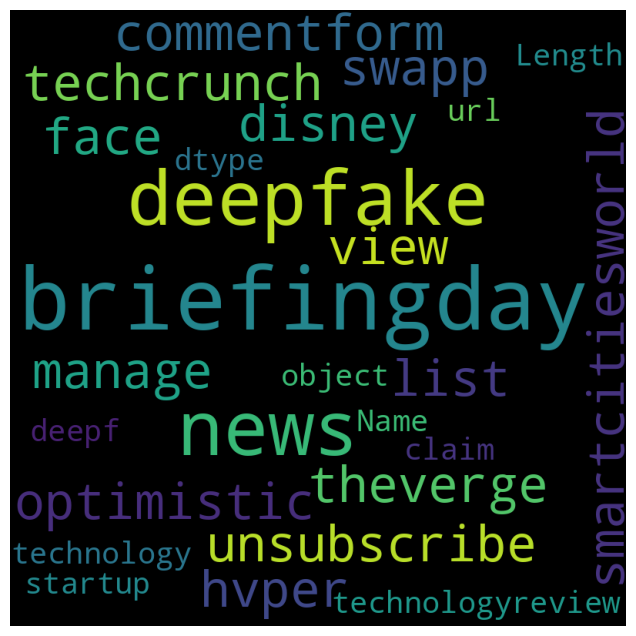

In [15]:
wordcloud = WordCloud(width=800,
                      height=800,
                      background_color="black",
                      max_words=1000,
                      min_font_size=20,
                      random_state=18).generate(str(df["url"]))

fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Vectorizamos

In [16]:
tokens_list = df["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features=5000,
                             max_df=0.8,
                             min_df=5)

X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 546))

In [17]:
with open('../models/12_vectorizer_nlp_url_spam.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [18]:
X.shape

(2369, 546)

In [19]:
y

0       1
1       1
2       1
3       0
4       1
       ..
2364    0
2365    0
2366    0
2367    0
2368    0
Name: is_spam, Length: 2369, dtype: int64

### Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


## Paso 3: Construye un SVM
Comienza a resolver el problema implementando un SVM con los parámetros por defecto. Entrénalo y analiza sus resultados.


In [21]:
model = SVC(kernel="linear",
            random_state=42)

model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [22]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [23]:
accuracy_score(y_test, y_pred)

0.9514767932489452


### Paso 4: Optimiza el modelo anterior
Después de entrenar el SVM, optimiza sus hiperparámetros utilizando un grid search o un random search.


In [24]:
# Hiperparametrización

# Defino parametros a probar.
hyperparams = {"C": [ 0.1, 0.5,  1, 2, 4, 5, 6, 7, 10, 100],
               "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
               "degree": [1, 2, 3, 4, 5, 7, 9],
               "gamma": ["scale", "auto"],
               "decision_function_shape":["ovo", "ovr"]}

# Implemento GridSearchCV
grid = GridSearchCV(SVC(kernel="linear", random_state=42), 
                     hyperparams, scoring = "accuracy", cv = 5)

#entrenamos
grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
grid.best_params_

KeyboardInterrupt: 

In [ ]:
model_2 = SVC(C = 4, degree = 2, gamma = "scale", kernel = "poly", 
              random_state = 42, decision_function_shape = "ovo" )

model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

accuracy_score(y_test, y_pred)

0.9556962025316456

### Observaciones:
> Aunque hemos hiperparametrizado con bastantes variables solo hemos conseguido mejorar unas décimas. De 95,15 a 95,57%

## Paso 5: Guarda el modelo
Almacena el modelo en la carpeta correspondiente.

In [ ]:
with open('../models/12_nlp_url_spam.pkl', 'wb') as f:
    pickle.dump(model_2, f)

# Extra!
Creo función para saber si una URL random sería spam o no.
en C:\Users\Usuario\Documents\GitHub\sarayruiz---Machine-Learning\src\12 prueba de modelo.ipynb